<a href="https://colab.research.google.com/github/PJZoio/DocProduct/blob/master/Iterative_PLS_(FTIR_NIR)_com_regularizacao_com_inferencia_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
import pickle
import matplotlib.pyplot as plt
from google.colab import files
import io

In [ ]:
# Load the dataset
uploaded = files.upload()

Saving Compostas (Novas-ureia) - Espetros.csv to Compostas (Novas-ureia) - Espetros.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['Compostas (Novas-ureia) - Espetros.csv']), delimiter=';', encoding='latin-1')
print(data)

    Unnamed: 0    Data  Estadio   Conc    12497,1   12495,17   12493,24  \
0        #1##1  jan/25        0     17  0,3190747  0,3190013  0,3184121   
1        #1##2  jan/25        0     17  0,3184985  0,3193123  0,3186378   
2        #1##3  jan/25        0     17  0,3175368  0,3171732  0,3170539   
3        #1##4  jan/25        0     17  0,3169154  0,3159791  0,3152222   
4        #1##5  jan/25        0     17  0,3188727  0,3191647  0,3183154   
..         ...     ...      ...    ...        ...        ...        ...   
265     #54##1  jan/25        5  170,2  0,2990442  0,2984389  0,2985225   
266     #54##2  jan/25        5  170,2  0,3004497  0,3007593  0,3000701   
267     #54##3  jan/25        5  170,2  0,2974475  0,2982265  0,2988065   
268     #54##4  jan/25        5  170,2  0,2990757  0,2983191  0,2977589   
269     #54##5  jan/25        5  170,2  0,2974968  0,2986111  0,2994829   

      12491,31   12489,38   12487,46  ...     4017,2   4015,271   4013,343  \
0    0,3178013  0,316

In [ ]:
# Replace commas with periods in numeric columns
for column in data.columns:
  # Check if the column data type is 'object' (likely string) before applying str methods
   if data[column].dtype == 'object':
    # Try converting the column to numeric, errors='coerce' will replace invalid values with NaN
    data[column] = pd.to_numeric(data[column].str.replace(',', '.'), errors='coerce')
    # Now fill NaN values with 0. This is a simple choice, consider other imputation strategies if necessary
    data[column] = data[column].fillna(0)

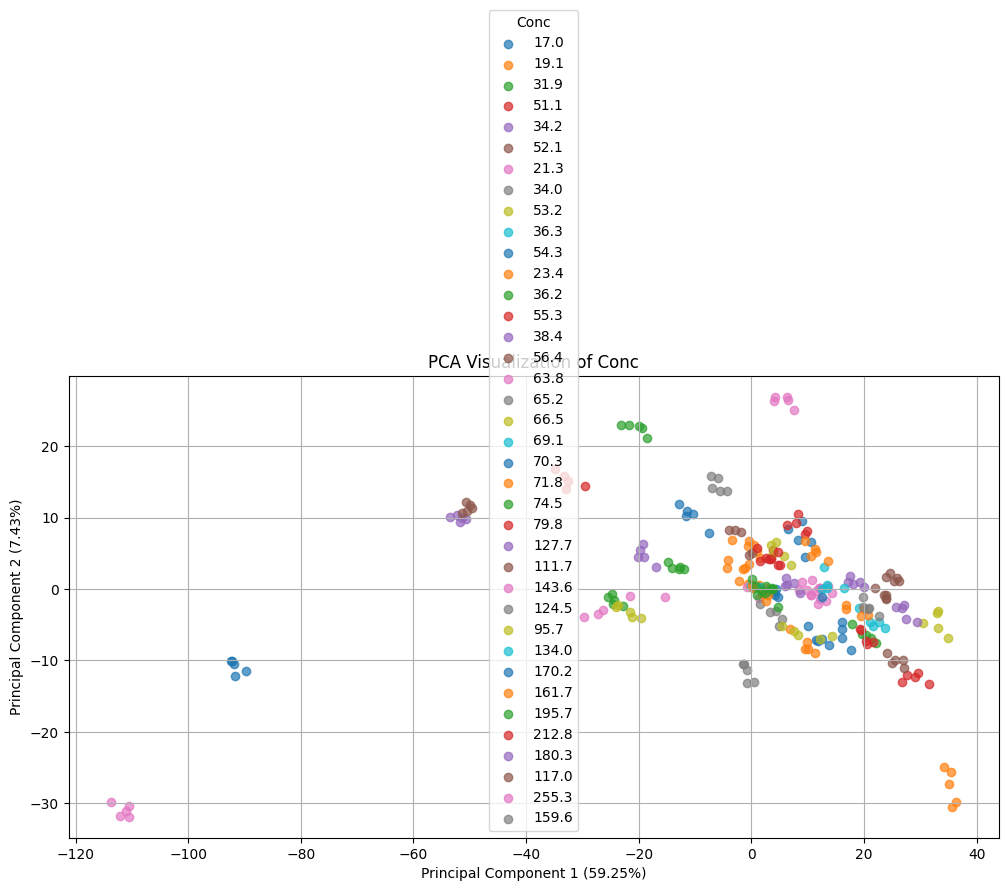

PLS + Ridge: R2 = 0.8539, RMSE = 19.4687


In [ ]:
# Extract the target and feature columns
target = data['Conc']
features = data.iloc[:, 4:]  # Assuming wavelength data starts at column E

# Function to evaluate a band with PLS and Ridge regularization
def evaluate_band_pls_ridge(start_col, end_col, n_components=4, alpha=1.0):
    # Select features within the current band
    band_features = features.iloc[:, start_col:start_col + end_col]
    X_train, X_test, y_train, y_test = train_test_split(band_features, target, test_size=0.3, random_state=42)

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

     # Scale the entire band_features for PCA
    features_scaled = scaler.fit_transform(band_features) # This line is added

    # Perform PCA
    pca = PCA(n_components=2)  # Use 2 components for visualization
    pca_components = pca.fit_transform(features_scaled)

    # Calculate explained variance percentages
    explained_variance = pca.explained_variance_ratio_ * 100

    # Create a DataFrame for visualization
    pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
    pca_df['Conc'] = target.values

    # Visualization of PCA results
    plt.figure(figsize=(12, 6))
    for label in pca_df['Conc'].unique():
        subset = pca_df[pca_df['Conc'] == label]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=label, alpha=0.7)

    plt.title('PCA Visualization of Conc')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}%)')
    plt.legend(title='Conc')
    plt.grid(True)
    plt.show()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

    # Fit the PLS model
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train_scaled, y_train)

    # Transform the data using PLS
    X_train_pls = pls.transform(X_train_scaled)
    X_test_pls = pls.transform(X_test_scaled)

    # Apply Ridge regression to the PLS-transformed data
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_pls, y_train)

    # Predict and calculate R2
    y_pred = ridge.predict(X_test_pls).flatten()
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, y_test, y_pred, X_train_scaled, scaler, pls, ridge, rmse

    print(f"PLS Regression on Selected Wavelengths: R2 = {r2:.4f}, RMSE = {rmse:.4f}, Latent Variables = {n_components}")

    # Plot actual vs predicted concentrations
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Concentrations')
    plt.ylabel('Predicted Concentrations')
    plt.title('PLS Regression: Actual vs Predicted Concentrations (Selected Wavelengths)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return pca_df, explained_variance, pls, scaler, r2, rmse

# Example usage: Manually select wavelengths from column 10 to 60
start_col = 1
end_col = 4407
r2, y_test, y_pred, X_train_scaled, scaler, pls, ridge, rmse = evaluate_band_pls_ridge(start_col, end_col, alpha=1.0)
print(f"PLS + Ridge: R2 = {r2:.4f}, RMSE = {rmse:.4f}")

PLS + Ridge Regression on Full Spectrum: R2 = 0.8170, RMSE = 474.6792, Latent Variables = 4


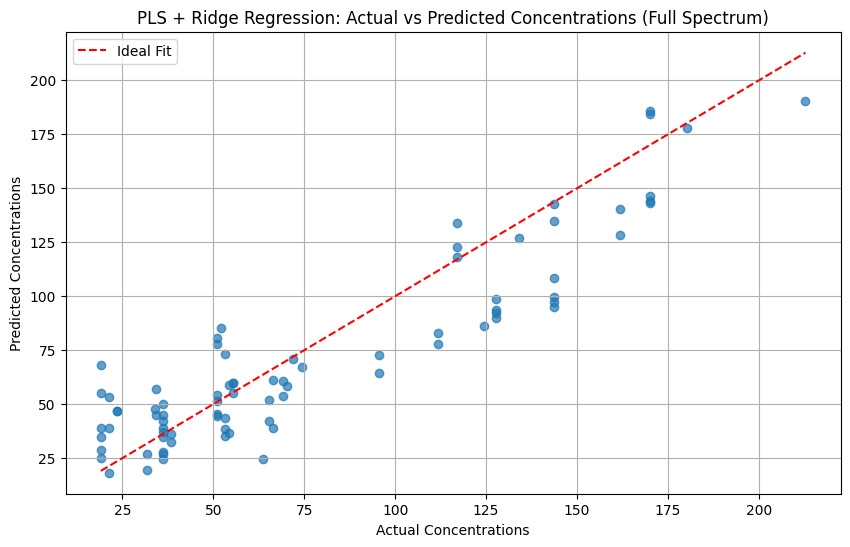

Best Band: Start Column = 4050, Width = 150, R2 = 0.84131959876989, RMSE = 20.286971734428946, Latent Variables = 4


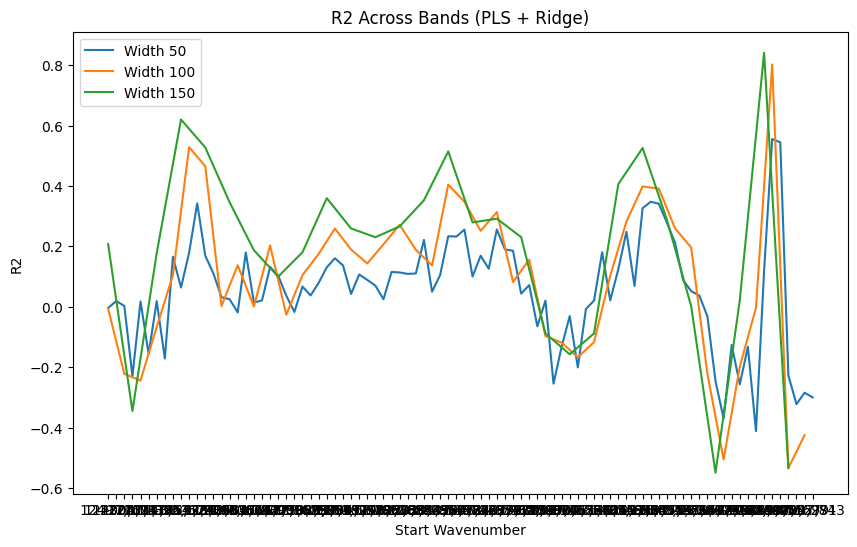

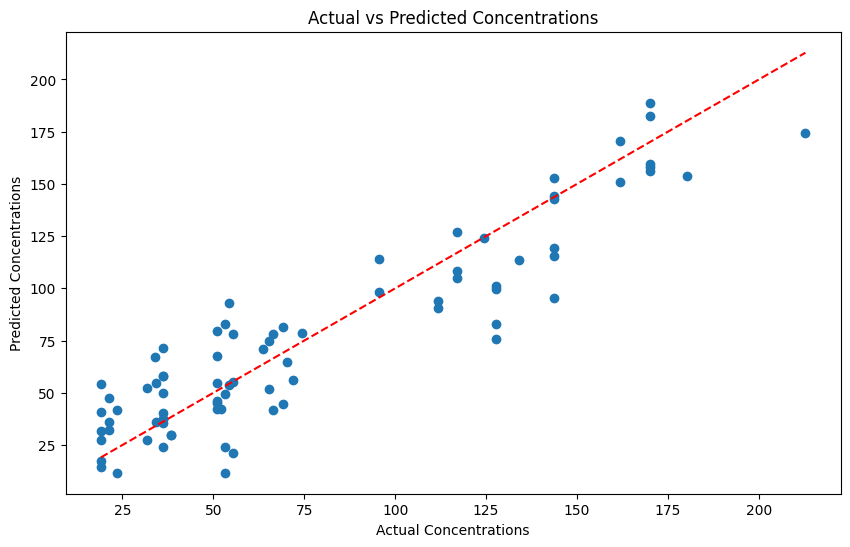

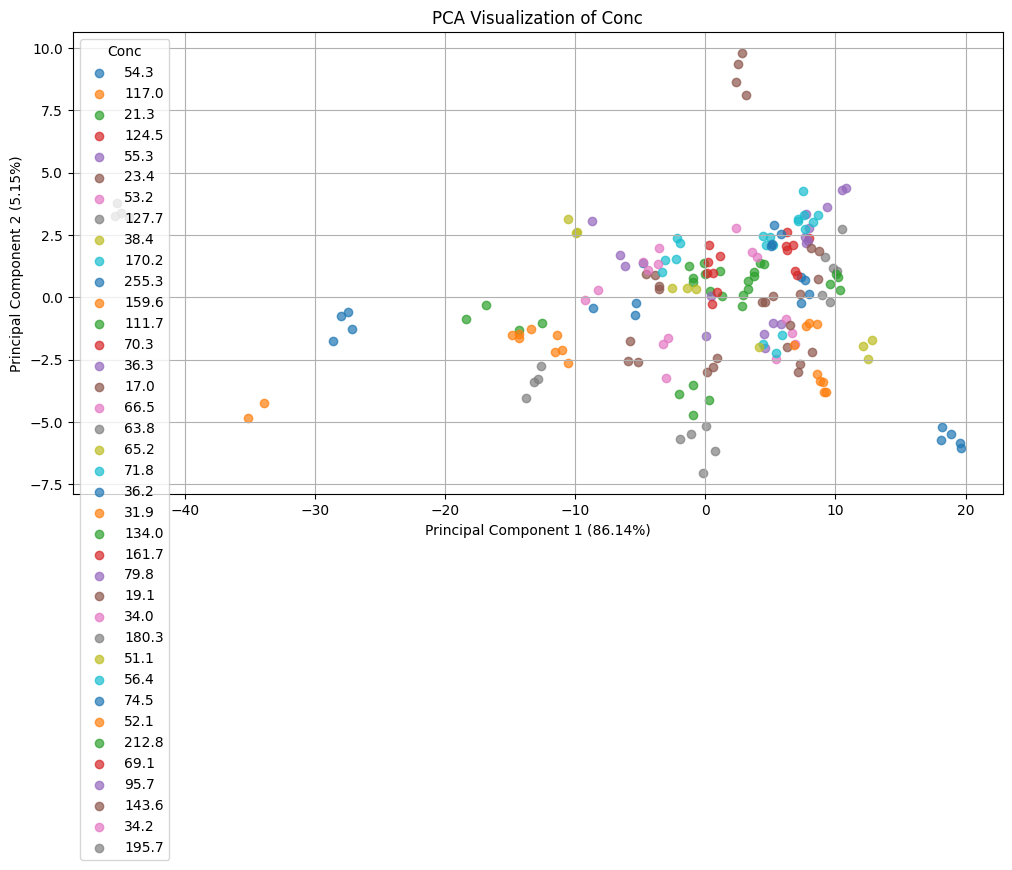

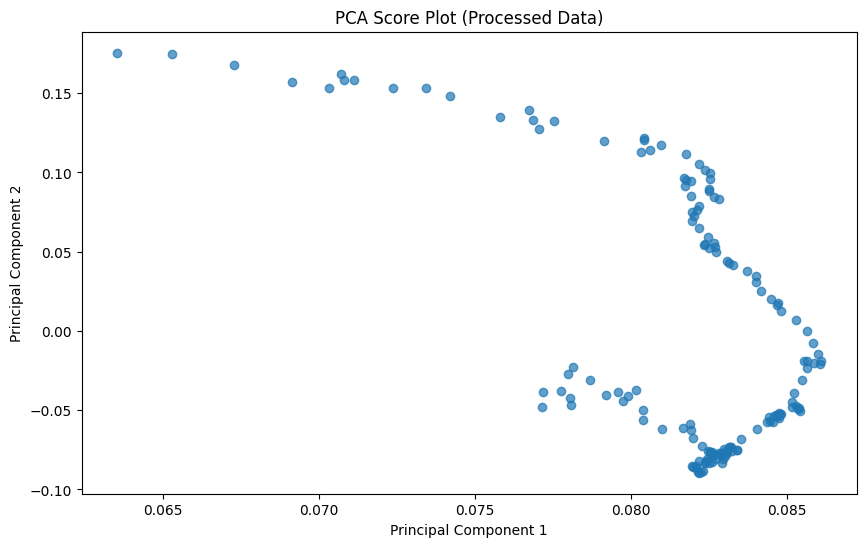

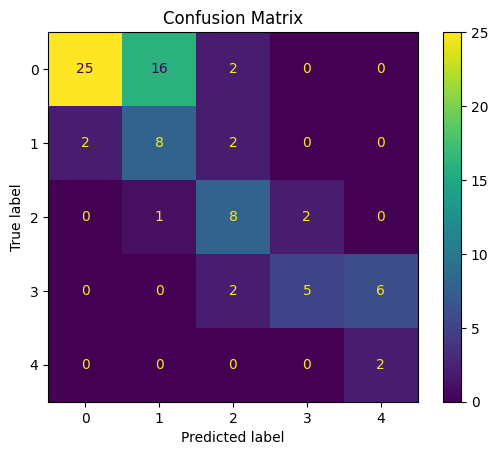

In [ ]:
# Function to perform PCA and return explained variance ratio and components
#def apply_pca(data, n_components=None):
    #pca = PCA(n_components=n_components)
    #transformed_data = pca.fit_transform(data)
    #explained_variance = pca.explained_variance_ratio_.sum()
    #return transformed_data, explained_variance, pca

# PLS Regression on the whole spectrum
n_components = 4  # Adjust the number of latent variables as needed
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# Fit the PLS model
pls = PLSRegression(n_components=n_components)
pls.fit(X_train, y_train)

# Transform the data using PLS
X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)

# Apply Ridge regression to the PLS-transformed data
ridge = Ridge(alpha=1.0)  # Adjust alpha for regularization strength
ridge.fit(X_train_pls, y_train)

# Predict and calculate metrics
y_pred = pls.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"PLS + Ridge Regression on Full Spectrum: R2 = {r2:.4f}, RMSE = {rmse:.4f}, Latent Variables = {n_components}")

# Plot actual vs predicted concentrations
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Concentrations')
plt.ylabel('Predicted Concentrations')
plt.title('PLS + Ridge Regression: Actual vs Predicted Concentrations (Full Spectrum)')
plt.legend()
plt.grid(True)
plt.show()

# Function to evaluate a band with PLS and Ridge regularization
def evaluate_band_pls_ridge(start_col, band_width, n_components=4, alpha=1.0):
    # Select features within the current band
    band_features = features.iloc[:, start_col:start_col + band_width]
    X_train, X_test, y_train, y_test = train_test_split(band_features, target, test_size=0.3, random_state=42)

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the PLS model
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train_scaled, y_train)

    # Transform the data using PLS
    X_train_pls = pls.transform(X_train_scaled)
    X_test_pls = pls.transform(X_test_scaled)

    # Apply Ridge regression to the PLS-transformed data
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_pls, y_train)

    # Predict and calculate R2
    y_pred = ridge.predict(X_test_pls).flatten()
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, y_test, y_pred, X_train_scaled, scaler, pls, ridge, rmse, X_train, y_train

# Iteratively evaluate bands
band_widths = [50, 100, 150]  # Define possible band widths
best_r2 = -np.inf
best_band = None
results = []
best_y_test = None # Initialize best_y_test
best_y_pred = None # Initialize best_y_pred
best_pca_model = None # Initialize best_pca_model
best_pca_explained_variance_ratio_ = None # Initialize best_pca_explained_variance_ratio_
best_scaler = None  # Initialize best_scaler outside the loop
best_X_train = None # Initialize best_X_train to store the training data for the best band
best_y_train = None # Initialize best_y_train to store the training target for the best band
best_pls_model = None  # Initialize best_pls_model
best_ridge_model = None  # Initialize best_ridge_model

for band_width in band_widths:
    for start_col in range(0, features.shape[1] - band_width + 1, band_width):  # Slide over features
        r2, y_test, y_pred, X_train_scaled, scaler, pls, ridge, rmse, X_train, y_train = evaluate_band_pls_ridge(
            start_col, band_width, n_components=n_components, alpha=1.0
        )
        results.append({'start_col': start_col, 'band_width': band_width, 'R2': r2, 'RMSE': rmse, 'Latent Variables': n_components})
        if r2 > best_r2:
            best_r2 = r2
            best_band = (start_col, band_width)
            best_y_test = y_test # Store y_test for the best band
            best_y_pred = y_pred # Store y_pred for the best band
            best_scaler = scaler # Store the scaler for the best band
            best_X_train = X_train # Store X_train for the best band
            best_y_train = y_train # Store y_train for the best band
            best_pls_model = pls  # Store the best PLS model
            best_ridge_model = ridge  # Store the best Ridge model

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Display the best band
print(f"Best Band: Start Column = {best_band[0]}, Width = {best_band[1]}, R2 = {best_r2}, RMSE = {results_df.loc[results_df['R2'].idxmax(), 'RMSE']}, Latent Variables = {n_components}") # Access RMSE from results_df

# Visualization (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for band_width in band_widths:
    subset = results_df[results_df['band_width'] == band_width]
    start_wavenumbers = [features.columns[i] for i in subset['start_col']]
    plt.plot(start_wavenumbers, subset['R2'], label=f'Width {band_width}')
plt.xlabel('Start Wavenumber')
plt.ylabel('R2')
plt.legend()
plt.title('R2 Across Bands (PLS + Ridge)')
plt.show()

# Plot actual vs predicted concentrations
plt.figure(figsize=(10, 6))
plt.scatter(best_y_test, best_y_pred)
plt.plot([best_y_test.min(), best_y_test.max()], [best_y_test.min(), best_y_test.max()], 'r--')
plt.xlabel('Actual Concentrations')
plt.ylabel('Predicted Concentrations')
plt.title('Actual vs Predicted Concentrations')
plt.show()

# Save the best model using the captured best_pls and best_scaler
with open('best_pls_model.pkl', 'wb') as file:
    pickle.dump((best_pls_model, best_scaler, best_band), file)

# Fit PCA on the best band features
pca = PCA(n_components=4)  # Adjust n_components as needed
best_pca_model = pca.fit(scaler.fit_transform(best_X_train)) # Fit PCA to the scaled training data
best_pca_explained_variance_ratio_ = best_pca_model.explained_variance_ratio_ #Store explained variance ratio

# Add the PCA components to the dataframe for visualization
pca_components = best_pca_model.transform(scaler.transform(best_X_train))  # Get PCA components from the scaled data
pca_df = pd.DataFrame(pca_components[:, :2], columns=['PCA1', 'PCA2']) # Select the first 2 components
pca_df['Conc'] = best_y_train.values  # Add the corresponding target values (y_train)

# Calculate explained variance percentages
best_pca_explained_variance_ratio_ = best_pca_model.explained_variance_ratio_ * 100

# Visualization of PCA results
plt.figure(figsize=(12, 6))
for label in pca_df['Conc'].unique():
    subset = pca_df[pca_df['Conc'] == label]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=label, alpha=0.7)

plt.title('PCA Visualization of Conc')
plt.xlabel(f'Principal Component 1 ({best_pca_explained_variance_ratio_[0]:.2f}%)')
plt.ylabel(f'Principal Component 2 ({best_pca_explained_variance_ratio_[1]:.2f}%)')
plt.legend(title='Conc')
plt.grid(True)
plt.show()



# Visualize PCA components - Raw data
#plt.figure(figsize=(10, 6))
#plt.scatter(best_raw_pca.components_[0], best_raw_pca.components_[1], alpha=0.7)
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.title('PCA Score Plot (Raw Data)')
#plt.show()

# Visualize PCA components- Processed data
plt.figure(figsize=(10, 6))
plt.scatter(best_pca_model.components_[0], best_pca_model.components_[1], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Score Plot (Processed Data)')
plt.show()

# Adjust confusion matrix for multi-class (use bins for classification)
num_bins = 5  # Example: categorize concentrations into 5 bins
y_test_bins = pd.cut(best_y_test, bins=num_bins, labels=False)
y_pred_bins = pd.cut(best_y_pred, bins=num_bins, labels=False)
conf_matrix = confusion_matrix(y_test_bins, y_pred_bins)
display_labels = np.arange(num_bins)
ConfusionMatrixDisplay(conf_matrix, display_labels=display_labels).plot()
plt.title(f"Confusion Matrix")
plt.show()



In [ ]:
# Save the best model using the captured best_pls and best_scaler
with open('best_pls_model.pkl', 'wb') as file:
    pickle.dump((best_pls_model, best_scaler, best_band), file)

In [ ]:
loaded_model = pickle.load(open('best_pls_model.pkl','rb'))
best_pls_model, best_scaler, best_band = loaded_model

In [ ]:
uploaded = files.upload()

Saving Sol compostas (ureia)_inferencia.csv to Sol compostas (ureia)_inferencia (1).csv


In [ ]:
# Load new dataset for inference
inference_data = pd.read_csv('Sol compostas (ureia)_inferencia (1).csv', delimiter=';', encoding='latin-1')

Inference completed. Results saved to 'inference_results.csv'.


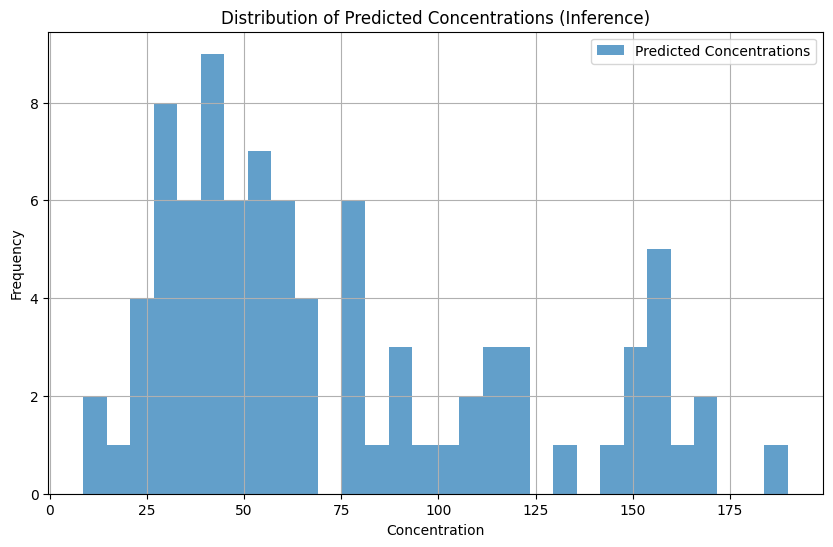

In [ ]:
# Replace commas with periods in numeric columns
for column in inference_data.columns:
    if inference_data[column].dtype == 'object':
        inference_data[column] = pd.to_numeric(inference_data[column].str.replace(',', '.'), errors='coerce').fillna(0)

# Extract features and reduce to the best band
inference_features = inference_data.iloc[:, 4:]

# Get the best band information
band_start, band_width = best_band

# Ensure inference_band has the same columns as the training data
# Get the column names used during training
training_columns = features.columns[band_start:band_start + band_width]

# Select the corresponding columns from inference_features
# Reindex if necessary to handle missing/extra columns
inference_band = inference_features.reindex(columns=training_columns, fill_value=0)

# Preprocess inference data using the same scaler as in training
inference_scaled = best_scaler.transform(inference_band)

# Perform prediction using the best PLS model
predicted_conc = best_pls_model.predict(inference_scaled).flatten()

# Append predictions to the dataset
inference_data = pd.concat([inference_data, pd.DataFrame({'Predicted_Conc': predicted_conc})], axis=1)

# Save the resulting dataset
inference_data.to_csv('inference_results.csv', index=False, sep=';')
print("Inference completed. Results saved to 'inference_results.csv'.")

# Plot inference data distribution
plt.figure(figsize=(10, 6))
plt.hist(predicted_conc, bins=30, alpha=0.7, label='Predicted Concentrations')
plt.title('Distribution of Predicted Concentrations (Inference)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
files.download('inference_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>